# Perfiles Individuales de Participantes

Este notebook genera **visualizaciones detalladas** de cada participante para enriquecer el análisis y permitir interpretación cualitativa.

##  Objetivos

1. **Fichas individuales** con radar chart de cada participante
2. **Heatmap comparativo** de todos los participantes
3. **Ranking** de indicadores destacados
4. **Casos extremos** identificados automáticamente
5. **Tabla resumen** exportable con todos los perfiles


In [1]:
# Importar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from matplotlib.patches import Rectangle
import warnings
warnings.filterwarnings('ignore')

# Configuración
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('Set2')
%matplotlib inline

# Colores personalizados
COLORES = {
    'positivo': '#2ecc71',
    'negativo': '#e74c3c',
    'neutral': '#95a5a6',
    'alta': '#e74c3c',
    'moderada': '#f39c12',
    'baja': '#27ae60',
    'normal': '#3498db'
}

print("✓ Librerías importadas")

✓ Librerías importadas


## 1. Cargar Datos

In [2]:
# Cargar dataset consolidado
df = pd.read_csv('../data/features/final/dataset_consolidado.csv')

print(f"Dataset cargado: {len(df)} participantes")

# Crear carpeta de salida
output_path = Path('../data/results/perfiles_individuales')
output_path.mkdir(exist_ok=True, parents=True)

print(f"✓ Carpeta de salida: {output_path}")

df.head()

Dataset cargado: 18 participantes
✓ Carpeta de salida: ../data/results/perfiles_individuales


,id_participante,num_publicaciones,promedio_palabras,promedio_caracteres,promedio_longitud_palabra,promedio_palabras_unicas,promedio_riqueza_lexica,promedio_exclamaciones,promedio_preguntas,promedio_pronombres_1era_sing,...,actividades_extra,miembro_wa,ucla_total,ucla_categoria,dass_depresion,dass_ansiedad,dass_estres,dass_depresion_cat,dass_ansiedad_cat,dass_estres_cat
0,EST001,1515,11.672607,62.170297,4.397393,10.619142,0.960832,0.006601,0.145875,1.619723,...,Sí,Sí,54,Alta soledad,28,10,28,Extremadamente severa,Moderada,Severo
1,EST002,589,9.509338,50.213922,4.310645,8.887946,0.976294,0.000000,0.110357,2.251290,...,No,Sí,44,Alta soledad,12,4,14,Leve,Normal,Normal
2,EST003,454,8.088106,48.504405,5.374670,7.568282,0.986749,0.033040,0.079295,1.486652,...,No,Sí,47,Alta soledad,20,20,30,Moderada,Extremadamente severa,Severo
3,EST004,1056,8.012311,40.735795,4.139915,7.578598,0.979777,0.009470,0.148674,1.886913,...,No,Sí,52,Alta soledad,18,30,30,Moderada,Extremadamente severa,Severo
4,EST007,723,10.507607,56.074689,4.329696,9.652835,0.960315,0.030429,0.069156,1.812573,...,Sí,Sí,57,Alta soledad,8,24,34,Normal,Extremadamente severa,Extremadamente severo


## 2. Definir Indicadores Clave para Perfiles

In [4]:
# Indicadores digitales principales (ordenados por categoría)
indicadores_perfil = {
    'Emocionales': [
        'promedio_score_negativo',
        'promedio_score_positivo',
        'promedio_tristeza',
        'promedio_alegria',
        'promedio_enojo',
        'promedio_miedo'
    ],
    'Lingüísticos': [
        'promedio_negativas',
        'promedio_absolutistas',
        'promedio_pronombres_1era_sing',
        'promedio_palabras',
        'promedio_riqueza_lexica'
    ],
    'Actividad': [
        'num_publicaciones',
        'total_emojis',
        'promedio_emojis_por_palabra'
    ]
}

# Todos los indicadores en lista plana
todos_indicadores = [ind for categoria in indicadores_perfil.values() for ind in categoria]

# Variables de salud mental
variables_salud = ['dass_depresion', 'dass_ansiedad', 'dass_estres', 'ucla_total']

print(f" Indicadores digitales: {len(todos_indicadores)}")
print(f" Variables de salud mental: {len(variables_salud)}")

 Indicadores digitales: 14
 Variables de salud mental: 4


## 3. Normalizar Datos (para comparaciones visuales)

In [5]:
# Normalizar cada indicador a escala 0-1 (para visualización)
df_norm = df.copy()

for ind in todos_indicadores:
    if ind in df_norm.columns:
        min_val = df_norm[ind].min()
        max_val = df_norm[ind].max()
        
        if max_val - min_val > 0:
            df_norm[f'{ind}_norm'] = (df_norm[ind] - min_val) / (max_val - min_val)
        else:
            df_norm[f'{ind}_norm'] = 0.5  # Si todos iguales, dejar en medio

print("✓ Datos normalizados (0-1) para visualización")

✓ Datos normalizados (0-1) para visualización


## 4. Función: Crear Ficha Individual (Radar Chart + Métricas)

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec

def crear_ficha_participante(participante_id, df_original, df_normalizado, output_folder):
    """
    Crea una ficha visual completa y equilibrada de un participante.
    """

    # Datos del participante
    datos = df_original[df_original['id_participante'] == participante_id].iloc[0]
    datos_norm = df_normalizado[df_normalizado['id_participante'] == participante_id].iloc[0]
    
    # Figura general
    fig = plt.figure(figsize=(16, 10))
    gs = GridSpec(3, 3, figure=fig, hspace=0.6, wspace=0.5)
    
    # ======== SECCIÓN 1: RADAR CHART =========
    ax_radar = fig.add_subplot(gs[0:2, 0], projection='polar')
    emocionales = indicadores_perfil['Emocionales']
    valores_norm = [datos_norm[f'{ind}_norm'] for ind in emocionales]
    labels_radar = ['Negativo','Positivo','Tristeza','Alegría','Enojo','Miedo']
    angles = np.linspace(0, 2*np.pi, len(emocionales), endpoint=False).tolist()
    valores_norm += valores_norm[:1]
    angles += angles[:1]
    
    ax_radar.plot(angles, valores_norm, 'o-', linewidth=2, color='#3498db')
    ax_radar.fill(angles, valores_norm, alpha=0.25, color='#3498db')
    ax_radar.set_xticks(angles[:-1])
    ax_radar.set_xticklabels(labels_radar, fontsize=10)
    ax_radar.set_ylim(0, 1)
    ax_radar.set_title('Perfil Emocional', fontsize=12, fontweight='bold', pad=20)
    ax_radar.grid(True, alpha=0.4)
    
    # ======== SECCIÓN 2: LINGÜÍSTICOS ========
    ax_ling = fig.add_subplot(gs[0:2, 1])
    linguisticos = indicadores_perfil['Lingüísticos']
    valores_ling = [datos_norm[f'{ind}_norm'] for ind in linguisticos]
    labels_ling = ['Pal. Negativas','Absolutistas','Pronombres 1era','N° Palabras','Riqueza Léxica']
    y_pos = np.arange(len(linguisticos))
    colors_ling = ['#e74c3c','#e67e22','#f39c12','#3498db','#9b59b6']
    
    ax_ling.barh(y_pos, valores_ling, color=colors_ling, alpha=0.8)
    ax_ling.set_yticks(y_pos)
    ax_ling.set_yticklabels(labels_ling, fontsize=10)
    ax_ling.set_xlim(0, 1)
    ax_ling.set_xlabel('Valor Normalizado (0-1)', fontsize=10)
    ax_ling.set_title('Indicadores Lingüísticos', fontsize=12, fontweight='bold', pad=10)
    ax_ling.grid(axis='x', alpha=0.3)
    
    # ======== SECCIÓN 3 y 4: ACTIVIDAD Y SALUD ========
    ax_act = fig.add_subplot(gs[0, 2])
    ax_salud = fig.add_subplot(gs[1, 2])
    for ax in [ax_act, ax_salud]:
        ax.axis('off')

    # Texto con padding uniforme
    actividad_text = f"""
  ACTIVIDAD DIGITAL
────────────────────────
 Publicaciones: {int(datos['num_publicaciones'])}
 Emojis totales: {int(datos['total_emojis'])}
 Emojis/palabra: {datos['promedio_emojis_por_palabra']:.3f}
 Palabras/post: {datos['promedio_palabras']:.1f}
 Riqueza léxica: {datos['promedio_riqueza_lexica']:.3f}
"""
    ax_act.text(0.05, 0.5, actividad_text.strip(),
                fontsize=11, verticalalignment='center',
                family='monospace',
                bbox=dict(boxstyle='round,pad=0.6', facecolor='wheat', alpha=0.35))
    
    # Salud mental
    ucla_val = datos['ucla_total']
    dep_val, ans_val, est_val = datos['dass_depresion'], datos['dass_ansiedad'], datos['dass_estres']
    salud_text = f"""
  SALUD MENTAL
────────────────────────
UCLA Soledad: {ucla_val:.0f}
Categoría: {datos.get('ucla_categoria', 'N/A')}

DASS-21:
• Depresión: {dep_val:.0f} ({datos.get('dass_depresion_cat', 'N/A')})
• Ansiedad: {ans_val:.0f} ({datos.get('dass_ansiedad_cat', 'N/A')})
• Estrés: {est_val:.0f} ({datos.get('dass_estres_cat', 'N/A')})
"""
    ax_salud.text(0.05, 0.5, salud_text.strip(),
                  fontsize=10, verticalalignment='center',
                  family='monospace',
                  bbox=dict(boxstyle='round,pad=0.6', facecolor='lightblue', alpha=0.3))
    
    # ======== SECCIÓN 5: TOP INDICADORES ========
    ax_top = fig.add_subplot(gs[2, :])
    ax_top.axis('off')
    
    percentiles = {}
    for ind in todos_indicadores:
        if ind in df_original.columns:
            valor = datos[ind]
            percentil = (df_original[ind] < valor).sum() / len(df_original) * 100
            percentiles[ind] = percentil

    top_altos = sorted(percentiles.items(), key=lambda x: x[1], reverse=True)[:5]
    top_bajos = sorted(percentiles.items(), key=lambda x: x[1])[:5]
    
    resumen_text = (
        "  INDICADORES DESTACADOS (Percentil vs grupo)\n"
        "────────────────────────\n\n"
        "  MÁS ALTOS:\n" +
        '\n'.join([f"   • {ind.replace('promedio_', '').replace('_', ' ').title()}: P{perc:.0f}"
                  for ind, perc in top_altos]) +
        "\n\n  MÁS BAJOS:\n" +
        '\n'.join([f"   • {ind.replace('promedio_', '').replace('_', ' ').title()}: P{perc:.0f}"
                  for ind, perc in top_bajos])
    )
    
    ax_top.text(0.03, 0.5, resumen_text,
                fontsize=10, verticalalignment='center',
                family='monospace',
                bbox=dict(boxstyle='round,pad=0.6', facecolor='lightyellow', alpha=0.4))
    
    # ======== TÍTULO GENERAL ========
    fig.suptitle(f'PERFIL COMPORTAMENTAL: {participante_id}',
                 fontsize=18, fontweight='bold', y=0.98)
    
    # Ajuste final de márgenes
    fig.subplots_adjust(left=0.06, right=0.94, top=0.93, bottom=0.05)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    
    # Guardar
    filename = output_folder / f'ficha_{participante_id}.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight', facecolor='white')
    plt.close()
    return filename

print("✓ Función crear_ficha_participante() mejorada y lista 🎨")


✓ Función crear_ficha_participante() mejorada y lista 🎨


## 5. Generar Fichas para Todos los Participantes

In [7]:
print("Generando fichas individuales...\n")

fichas_generadas = []

for idx, participante in enumerate(df['id_participante'], 1):
    print(f"  [{idx}/{len(df)}] Generando ficha: {participante}")
    
    filename = crear_ficha_participante(
        participante_id=participante,
        df_original=df,
        df_normalizado=df_norm,
        output_folder=output_path
    )
    
    fichas_generadas.append(filename)

print(f"\n✓ {len(fichas_generadas)} fichas generadas en: {output_path}")

Generando fichas individuales...

  [1/18] Generando ficha: EST001
  [2/18] Generando ficha: EST002
  [3/18] Generando ficha: EST003
  [4/18] Generando ficha: EST004
  [5/18] Generando ficha: EST007
  [6/18] Generando ficha: EST008
  [7/18] Generando ficha: EST009
  [8/18] Generando ficha: EST010
  [9/18] Generando ficha: EST011
  [10/18] Generando ficha: EST012
  [11/18] Generando ficha: EST013
  [12/18] Generando ficha: EST014
  [13/18] Generando ficha: EST015
  [14/18] Generando ficha: EST016
  [15/18] Generando ficha: EST017
  [16/18] Generando ficha: EST018
  [17/18] Generando ficha: EST020
  [18/18] Generando ficha: EST021

✓ 18 fichas generadas en: ../data/results/perfiles_individuales


## 6. Heatmap Comparativo: Todos los Participantes

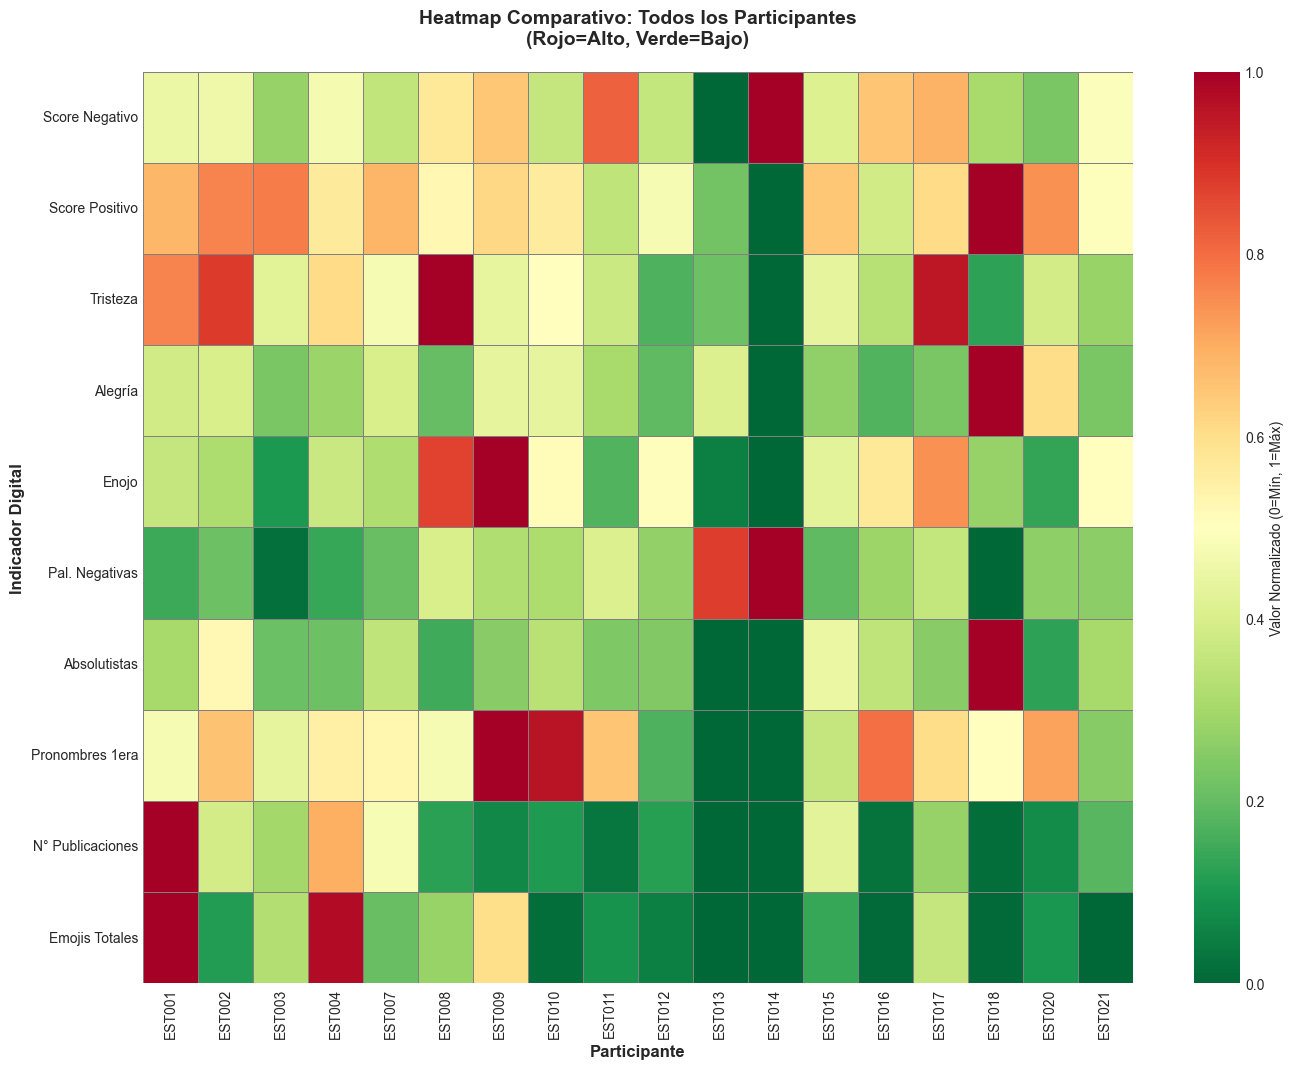

✓ Heatmap guardado: ../data/results/heatmap_participantes.pdf


In [15]:
# Crear heatmap con todos los participantes (normalizado)
fig, ax = plt.subplots(figsize=(14, max(8, len(df)*0.6)))

# Seleccionar indicadores clave para el heatmap
indicadores_heatmap = [
    'promedio_score_negativo',
    'promedio_score_positivo',
    'promedio_tristeza',
    'promedio_alegria',
    'promedio_enojo',
    'promedio_negativas',
    'promedio_absolutistas',
    'promedio_pronombres_1era_sing',
    'num_publicaciones',
    'total_emojis'
]

# Preparar datos
data_heatmap = df.set_index('id_participante')[indicadores_heatmap]

# Normalizar para heatmap (0-1)
data_heatmap_norm = (data_heatmap - data_heatmap.min()) / (data_heatmap.max() - data_heatmap.min())

# Crear heatmap
sns.heatmap(
    data_heatmap_norm.T,  # Transponer: indicadores en filas, participantes en columnas
    cmap='RdYlGn_r',  # Rojo=Alto, Verde=Bajo (invertido para negativos)
    annot=False,
    cbar_kws={'label': 'Valor Normalizado (0=Mín, 1=Máx)'},
    linewidths=0.5,
    linecolor='gray',
    ax=ax
)

# Etiquetas
labels_y = [
    'Score Negativo',
    'Score Positivo',
    'Tristeza',
    'Alegría',
    'Enojo',
    'Pal. Negativas',
    'Absolutistas',
    'Pronombres 1era',
    'N° Publicaciones',
    'Emojis Totales'
]

ax.set_yticklabels(labels_y, rotation=0, fontsize=10)
ax.set_xlabel('Participante', fontsize=12, fontweight='bold')
ax.set_ylabel('Indicador Digital', fontsize=12, fontweight='bold')
ax.set_title(
    'Heatmap Comparativo: Todos los Participantes\n(Rojo=Alto, Verde=Bajo)',
    fontsize=14,
    fontweight='bold',
    pad=20
)

plt.tight_layout()
plt.savefig(output_path.parent / 'heatmap_participantes.pdf', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Heatmap guardado: {output_path.parent / 'heatmap_participantes.pdf'}")

## 7. Identificar Casos Extremos / Interesantes

In [10]:
print("=" * 80)
print("CASOS EXTREMOS IDENTIFICADOS")
print("=" * 80 + "\n")

casos_interesantes = {}

# 1. Mayor soledad (UCLA)
max_ucla = df.loc[df['ucla_total'].idxmax()]
casos_interesantes['Mayor Soledad'] = max_ucla['id_participante']
print(f" Mayor Soledad: {max_ucla['id_participante']}")
print(f"   UCLA: {max_ucla['ucla_total']:.0f}")
print(f"   DASS Depresión: {max_ucla['dass_depresion']:.0f}")
print(f"   Score Negativo: {max_ucla['promedio_score_negativo']:.3f}\n")

# 2. Mayor depresión (DASS)
max_dep = df.loc[df['dass_depresion'].idxmax()]
casos_interesantes['Mayor Depresión'] = max_dep['id_participante']
print(f" Mayor Depresión: {max_dep['id_participante']}")
print(f"   DASS Depresión: {max_dep['dass_depresion']:.0f}")
print(f"   Tristeza: {max_dep['promedio_tristeza']:.3f}")
print(f"   Palabras negativas: {max_dep['promedio_negativas']:.2f}\n")

# 3. Más activo en redes
max_pub = df.loc[df['num_publicaciones'].idxmax()]
casos_interesantes['Más Activo'] = max_pub['id_participante']
print(f" Más Activo (publicaciones): {max_pub['id_participante']}")
print(f"   Publicaciones: {max_pub['num_publicaciones']:.0f}")
print(f"   Emojis: {max_pub['total_emojis']:.0f}")
print(f"   UCLA: {max_pub['ucla_total']:.0f}\n")

# 4. Mayor contenido negativo
max_neg = df.loc[df['promedio_score_negativo'].idxmax()]
casos_interesantes['Mayor Negatividad'] = max_neg['id_participante']
print(f" Mayor Contenido Negativo: {max_neg['id_participante']}")
print(f"   Score Negativo: {max_neg['promedio_score_negativo']:.3f}")
print(f"   Tristeza: {max_neg['promedio_tristeza']:.3f}")
print(f"   DASS Depresión: {max_neg['dass_depresion']:.0f}\n")

# 5. Mayor contenido positivo
max_pos = df.loc[df['promedio_score_positivo'].idxmax()]
casos_interesantes['Mayor Positividad'] = max_pos['id_participante']
print(f" Mayor Contenido Positivo: {max_pos['id_participante']}")
print(f"   Score Positivo: {max_pos['promedio_score_positivo']:.3f}")
print(f"   Alegría: {max_pos['promedio_alegria']:.3f}")
print(f"   UCLA: {max_pos['ucla_total']:.0f}\n")

# 6. Menor soledad
min_ucla = df.loc[df['ucla_total'].idxmin()]
casos_interesantes['Menor Soledad'] = min_ucla['id_participante']
print(f" Menor Soledad: {min_ucla['id_participante']}")
print(f"   UCLA: {min_ucla['ucla_total']:.0f}")
print(f"   DASS Depresión: {min_ucla['dass_depresion']:.0f}")
print(f"   Score Positivo: {min_ucla['promedio_score_positivo']:.3f}\n")

print("=" * 80)
print(f"\n✓ {len(casos_interesantes)} casos extremos identificados")
print("\n Sugerencia: Analizar cualitativamente estos casos para la discusión")

CASOS EXTREMOS IDENTIFICADOS

 Mayor Soledad: EST010
   UCLA: 62
   DASS Depresión: 26
   Score Negativo: 0.240

 Mayor Depresión: EST011
   DASS Depresión: 32
   Tristeza: 0.016
   Palabras negativas: 2.89

 Más Activo (publicaciones): EST001
   Publicaciones: 1515
   Emojis: 274
   UCLA: 54

 Mayor Contenido Negativo: EST014
   Score Negativo: 0.501
   Tristeza: 0.003
   DASS Depresión: 4

 Mayor Contenido Positivo: EST018
   Score Positivo: 0.198
   Alegría: 0.129
   UCLA: 58

 Menor Soledad: EST016
   UCLA: 40
   DASS Depresión: 16
   Score Positivo: 0.082


✓ 6 casos extremos identificados

 Sugerencia: Analizar cualitativamente estos casos para la discusión


## 8. Tabla Resumen Exportable (Todos los Perfiles)

In [11]:
# Crear tabla resumen con métricas clave
columnas_resumen = [
    'id_participante',
    'num_publicaciones',
    'total_emojis',
    'promedio_score_negativo',
    'promedio_score_positivo',
    'promedio_tristeza',
    'promedio_alegria',
    'promedio_negativas',
    'promedio_absolutistas',
    'promedio_pronombres_1era_sing',
    'ucla_total',
    'ucla_categoria',
    'dass_depresion',
    'dass_depresion_cat',
    'dass_ansiedad',
    'dass_ansiedad_cat',
    'dass_estres',
    'dass_estres_cat'
]

# Filtrar columnas que existen
columnas_resumen = [col for col in columnas_resumen if col in df.columns]

df_resumen = df[columnas_resumen].copy()

# Redondear valores numéricos
for col in df_resumen.columns:
    if df_resumen[col].dtype in ['float64', 'float32']:
        df_resumen[col] = df_resumen[col].round(3)

# Guardar
archivo_resumen = output_path.parent / 'tabla_resumen_perfiles.csv'
df_resumen.to_csv(archivo_resumen, index=False, encoding='utf-8-sig')

print(f"✓ Tabla resumen guardada: {archivo_resumen}")
print(f"\nVista previa:")
display(df_resumen.head())

✓ Tabla resumen guardada: ../data/results/tabla_resumen_perfiles.csv

Vista previa:


,id_participante,num_publicaciones,total_emojis,promedio_score_negativo,promedio_score_positivo,promedio_tristeza,promedio_alegria,promedio_negativas,promedio_absolutistas,promedio_pronombres_1era_sing,ucla_total,ucla_categoria,dass_depresion,dass_depresion_cat,dass_ansiedad,dass_ansiedad_cat,dass_estres,dass_estres_cat
0,EST001,1515,274,0.277,0.138,0.029,0.052,1.710,1.067,1.620,54,Alta soledad,28,Extremadamente severa,10,Moderada,28,Severo
1,EST002,589,31,0.278,0.153,0.033,0.054,2.008,1.825,2.251,44,Alta soledad,12,Leve,4,Normal,14,Normal
2,EST003,454,89,0.205,0.156,0.018,0.033,1.131,0.737,1.487,47,Alta soledad,20,Moderada,20,Extremadamente severa,30,Severo
3,EST004,1056,267,0.284,0.117,0.024,0.039,1.674,0.747,1.887,52,Alta soledad,18,Moderada,30,Extremadamente severa,30,Severo
4,EST007,723,56,0.237,0.139,0.019,0.054,1.977,1.222,1.813,57,Alta soledad,8,Normal,24,Extremadamente severa,34,Extremadamente severo


## 9. Ranking de Participantes por Categoría

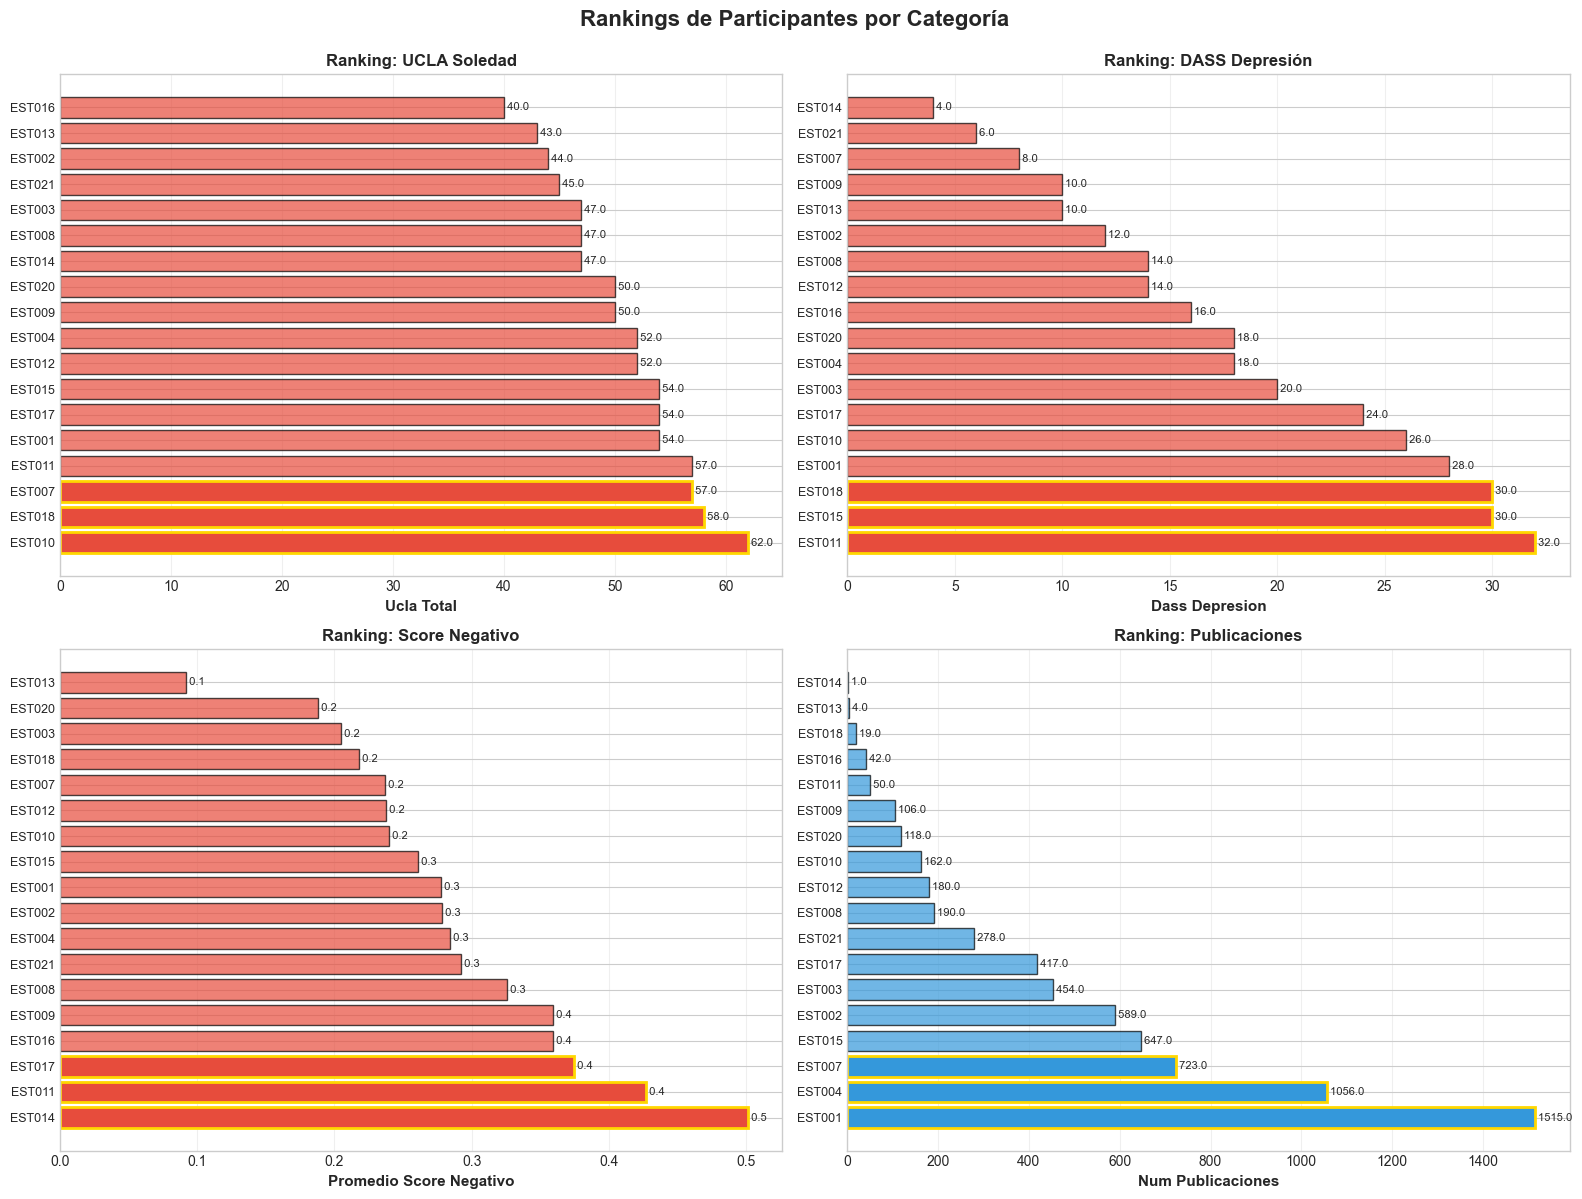

✓ Rankings guardados: ../data/results/rankings_participantes.pdf


In [16]:
# Crear rankings visuales
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

rankings = [
    ('UCLA Soledad', 'ucla_total', COLORES['alta']),
    ('DASS Depresión', 'dass_depresion', COLORES['alta']),
    ('Score Negativo', 'promedio_score_negativo', COLORES['negativo']),
    ('Publicaciones', 'num_publicaciones', '#3498db')
]

for idx, (titulo, columna, color) in enumerate(rankings):
    ax = axes[idx]
    
    # Ordenar participantes
    df_sorted = df.sort_values(columna, ascending=False)
    
    # Plot
    y_pos = np.arange(len(df_sorted))
    valores = df_sorted[columna].values
    
    bars = ax.barh(y_pos, valores, color=color, alpha=0.7, edgecolor='black')
    
    # Resaltar top 3
    for i in range(min(3, len(bars))):
        bars[i].set_alpha(1.0)
        bars[i].set_edgecolor('gold')
        bars[i].set_linewidth(2)
    
    ax.set_yticks(y_pos)
    ax.set_yticklabels(df_sorted['id_participante'].values, fontsize=9)
    ax.set_xlabel(columna.replace('_', ' ').title(), fontsize=11, fontweight='bold')
    ax.set_title(f'Ranking: {titulo}', fontsize=12, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    
    # Añadir valores
    for i, (bar, val) in enumerate(zip(bars, valores)):
        ax.text(val, bar.get_y() + bar.get_height()/2, 
                f' {val:.1f}', 
                va='center', fontsize=8)

plt.suptitle(
    'Rankings de Participantes por Categoría',
    fontsize=16,
    fontweight='bold',
    y=0.995
)
plt.tight_layout()
plt.savefig(output_path.parent / 'rankings_participantes.pdf', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Rankings guardados: {output_path.parent / 'rankings_participantes.pdf'}")

## 10. Resumen Final y Sugerencias

In [14]:
print("\n" + "=" * 80)
print("RESUMEN FINAL - PERFILES INDIVIDUALES")
print("=" * 80 + "\n")

print(f" Archivos generados:")
print(f"\n1. FICHAS INDIVIDUALES ({len(fichas_generadas)} archivos):")
print(f"   {output_path}/")
for ficha in fichas_generadas[:3]:
    print(f"   - {ficha.name}")
if len(fichas_generadas) > 3:
    print(f"   - ... y {len(fichas_generadas)-3} más")

print(f"\n2. VISUALIZACIONES COMPARATIVAS:")
print(f"   - {output_path.parent / 'heatmap_participantes.png'}")
print(f"   - {output_path.parent / 'rankings_participantes.png'}")

print(f"\n3. DATOS EXPORTABLES:")
print(f"   - {output_path.parent / 'tabla_resumen_perfiles.csv'}")

print(f"\n CASOS EXTREMOS IDENTIFICADOS:")
for caso, participante in casos_interesantes.items():
    print(f"   • {caso}: {participante}")


print("=" * 80)
print("\ Análisis de perfiles individuales COMPLETADO")
print("\n Ahora tienes datos cuantitativos Y cualitativos para tu tesis\n")


RESUMEN FINAL - PERFILES INDIVIDUALES

 Archivos generados:

1. FICHAS INDIVIDUALES (18 archivos):
   ../data/results/perfiles_individuales/
   - ficha_EST001.png
   - ficha_EST002.png
   - ficha_EST003.png
   - ... y 15 más

2. VISUALIZACIONES COMPARATIVAS:
   - ../data/results/heatmap_participantes.png
   - ../data/results/rankings_participantes.png

3. DATOS EXPORTABLES:
   - ../data/results/tabla_resumen_perfiles.csv

 CASOS EXTREMOS IDENTIFICADOS:
   • Mayor Soledad: EST010
   • Mayor Depresión: EST011
   • Más Activo: EST001
   • Mayor Negatividad: EST014
   • Mayor Positividad: EST018
   • Menor Soledad: EST016
\ Análisis de perfiles individuales COMPLETADO

 Ahora tienes datos cuantitativos Y cualitativos para tu tesis

